<a href="https://colab.research.google.com/github/eikeschuett/IcebergShipDetection/blob/main/CNN_training_iceberg_ship.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First, import all required libraries

In [12]:
# Libraries to access files from my drive
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
from keras_preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.optimizers import Adam

Mount drive and import data.

In [2]:
drive.mount('/content/drive')
data = pd.read_json('/content/drive/MyDrive/Iceberg_Ship_Classification/train.json')
print(data.columns)

Mounted at /content/drive
Index(['id', 'band_1', 'band_2', 'inc_angle', 'is_iceberg'], dtype='object')


Define a function for the lee filter, which we will use to denoise the radar images.

In [9]:
def lee_filter(img, size):
    # From here: https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

Define a function which prepares the data. The function reshapes each image into the correct 75x75 pixels format and creates a third band with the total backscater (HH+HV). It also rescales the pixel values between 0 and 1 and stacks the three bands in a single image. The dataset is then split into separate parts for for training (70 %), validation (20 %) and testing (10%).

In [10]:
def prepare_data(data):
  # data["inc_angle"] = data["inc_angle"].replace(["na"], np.nan)

  # Get the labels (y-values)
  labels = np.array(data["is_iceberg"])

  # Create empty list for the images
  imgs = []
  for i, row in data.iterrows():
      # Reshape list to image
      hh  = np.reshape(row["band_1"], (75, 75))
      hv  = np.reshape(row["band_2"], (75, 75))
      b3  = hh + hv

      hh = lee_filter(hh, 20)
      hv = lee_filter(hv, 20)
      b3 = lee_filter(b3, 20)      
        
      # Rescale images between 0 and 1 for faster convergence rate
      hh = (hh - hh.min())/(hh.max()-hh.min())
      hv = (hv - hv.min())/(hv.max()-hv.min())
      b3 = (b3 - b3.min())/(b3.max()-b3.min())      

      # Stack the bands and append them to imgs
      imgs.append(np.dstack((hh, hv, b3)))
      
  # Split dataset into training (70%)  and validation (30 %)
  x_train, x_val, y_train, y_val = train_test_split(imgs, 
                                                    labels, 
                                                    test_size=0.3, 
                                                    random_state=0)
  # Then split validation dataset into validation (20 %) and testing (10 %)
  x_val, x_test, y_val, y_test = train_test_split(x_val,
                                                  y_val,
                                                  test_size=(1/3),
                                                  random_state=0)

  x_train = np.array(x_train)
  x_test = np.array(x_test)
  x_val = np.array(x_val)
  return x_train, x_val, x_test, y_train, y_val, y_test

Next, define a function to set up DataGenerators.

In [4]:
def DataGenerators(x_train, x_val, y_train, y_val):
  training_datagen = ImageDataGenerator(
      rotation_range = 90,
      width_shift_range = 0.2,
      height_shift_range = 0.2,
      shear_range = 0.2,
      zoom_range = 0.2,
      horizontal_flip = True,
      fill_mode = 'nearest')

  train_generator = training_datagen.flow(x_train, y_train)#,
                                      #batch_size=64)#, 
                                      #subset = "training")

  val_datagen = ImageDataGenerator()

  val_generator = val_datagen.flow(x_val, y_val)#,
                                      #batch_size=16)#, 
                                      #subset = "training")
  
  return train_generator, val_generator

Set up and compile model

In [5]:
def create_model():
  model = tf.keras.models.Sequential([
      # Note the input shape is the desired size of the image 75x75 with 3 bytes color
      # This is the first convolution
      tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(75, 75, 3)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Dropout(0.2),
      # The second convolution
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Dropout(0.1),
      # The third convolution
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Dropout(0.1),
      # The fourth convolution
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Dropout(0.2),
      # Flatten the results to feed into a DNN
      tf.keras.layers.Flatten(),
      # 512 neuron hidden layer
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.BatchNormalization(renorm=True),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(128, activation='relu'),
      # Only 1 output neuron. It will contain a value from 0-1 where 0 means ship and 1 means iceberg
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  return model

Functions to compile and train the model

In [7]:
def compile_model(model, loss_function, optimizer):
  model.compile(loss=loss_function,
                optimizer=optimizer,
                metrics=['accuracy'])
  return model

def train_model(model, train_generator, val_generator):
  history = model.fit(
        train_generator,
        #steps_per_epoch=10,  
        epochs=200,
        verbose=1,
        validation_data = val_generator)#,
        #validation_steps=10)
  return model, history  

# Train model

Now prepare the data and split it into training, validation and test subsets.

In [25]:
x_train, x_val, x_test, y_train, y_val, y_test = prepare_data(data)
print("Number of samples for training: " + str(len(x_train)) + " (" + str(round(len(x_train)/len(data), 4)*100) + " %)")
print("Number of samples for validation: " + str(len(x_val)) + " (" + str(round(len(x_val)/len(data), 4)*100) + " %)")
print("Number of samples for testing: " + str(len(x_test)) + " (" + str(round(len(x_test)/len(data), 4)*100) + " %)")

Number of samples for training: 1122 (69.95 %)
Number of samples for validation: 321 (20.01 %)
Number of samples for testing: 161 (10.040000000000001 %)


Now train the model.

In [26]:
# Binary crossentropy + Adam
loss_function = 'binary_crossentropy'
optimizer = Adam(lr=0.001, decay=0.0)

train_generator, val_generator = DataGenerators(x_train, x_val, y_train, y_val)
model = create_model()
print(model.summary())

model = compile_model(model, loss_function, optimizer)
model, history = train_model(model, train_generator, val_generator)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 73, 73, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 36, 36, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 128)       1

Now evaluate the results with our test data.

In [27]:
results = model.evaluate(x_test, y_test)
print("Model test loss, test acc:", results)

6/6 [==============================] - 0s 6ms/step - loss: 0.3485 - accuracy: 0.8199
Model test loss, test acc: [0.34851324558258057, 0.8198757767677307]


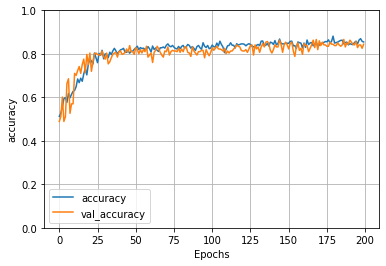

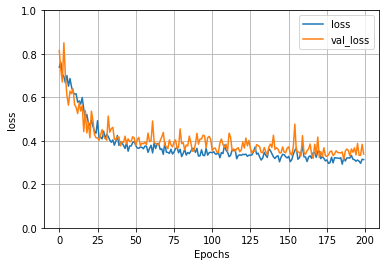

In [28]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.ylim([0,1])
  plt.grid()
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")